<pre style="text-align: right; width: 100%; font-size: 0.75em; line-height: 0.75em;">
+ ------------------------- + <br>
| 20/04/2025                | <br>
| Héctor Tablero Díaz       | <br>
| Álvaro Martínez Gamo      | <br>
+ ------------------------- + 
</pre>

# **Noise Schedulers**

In [1]:
import sys
sys.path.append('./..')

import os

import torch
from torch.utils.data import Subset
from torchvision import datasets
from torchvision.transforms import ToTensor

from image_gen import GenerativeModel
from image_gen.samplers import EulerMaruyama
from image_gen.diffusion import VariancePreserving
from image_gen.noise import LinearNoiseSchedule, CosineNoiseSchedule

import matplotlib.pyplot as plt
from IPython.display import HTML
from image_gen.visualization import display_images, create_evolution_widget

c:\Users\alva0\Desktop\3º ICID\2º cuatri\AAUTO3\proyecto\image-gen\examples\..\image_gen\samplers\euler_maruyama.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
epochs = 50
digit = 3

seed = 42

In [3]:
# Load the dataset
data = datasets.MNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor()
)

# Select a subset to speed up the training process
indices_digit = torch.where(data.targets == digit)[0]
data = Subset(data, indices_digit)

Noise schedulers control how noise is introduced during the diffusion process. The scheduling of $\beta_t$ (noise level at time $t$) significantly impacts:
- Training stability
- Sample quality
- Generation speed

Two primary schedules are implemented:

| Schedule Type | Key Characteristics                          | Best For                  |
|---------------|---------------------------------------------|--------------------------|
| [Linear](#linear) | Constant noise increase                  | Stable training          |
| [Cosine](#cosine) | Adaptive non-linear progression         | High-quality generation  |

### **Visual Comparison**

The schedules determine how much noise will be added over time. We can preview their impact by plotting the result of their `__call__` method:

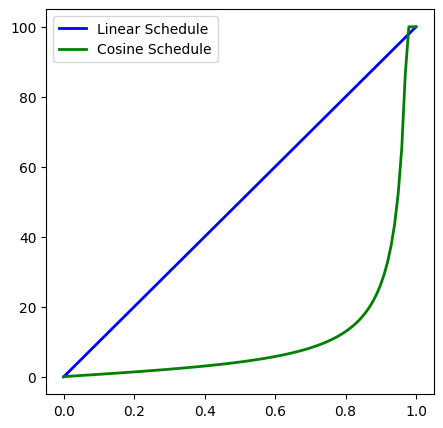

In [4]:
beta_max = 100.0
x = torch.linspace(0.0001, 0.9999, 100)

plt.figure(figsize=(5, 5))

lin_schedule = LinearNoiseSchedule(beta_max=beta_max)
plt.plot(x, lin_schedule(x), label='Linear Schedule', color='blue', linewidth=2)

cos_schedule = CosineNoiseSchedule(beta_max=beta_max)
plt.plot(x, cos_schedule(x), label='Cosine Schedule', color='green', linewidth=2)

plt.legend()
plt.show()

*Default schedules with $\beta_{max}=50.0$ showing fundamental curve differences*

### <span id="linear">**Linear Noise Schedule**</span>

#### Mathematical Definition
$$\beta_{t} = \beta_{\min} + (\beta_{\max} - \beta_{\min}) \cdot \frac{t}{T_{\max}}$$

#### Parameters
| Parameter  | Type | Default | Description                          |
|------------|---|---------|--------------------------------------|
| $\beta_{\min}$ (`beta_min`) | float | 0.001   | Minimum noise level                  |
| $\beta_{\max}$ (`beta_max`) | float | 50.0    | Maximum noise level                  |

#### Characteristics
- **Training**: Highly stable due to predictable gradient scaling
- **Generation**: Tends to produce smoother but less detailed outputs
- **Tuning Tip**: Lower $\beta_{\max}$ values (20-30) often work better for high-resolution images

#### Usage Example

In [5]:
model = GenerativeModel(
    diffusion=VariancePreserving,
    sampler=EulerMaruyama,
    noise_schedule=LinearNoiseSchedule(beta_max=50.0)
)

In [6]:
filename = f'saved_models/mnist_{digit}_vp-lin_euler_{epochs}e.pth'

if os.path.isfile(filename):
    model.load(filename)
else:
    model.train(data, epochs=epochs)
    # Tip: Save the models for them to be accessible through the dashboard
    model.save(filename)

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/192 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
n_images = 16
samples = model.generate(n_images, seed=seed)
display_images(samples)

In [ ]:
HTML(create_evolution_widget(model, seed=seed).to_jshtml(default_mode="once"))

### <span id="cosine">**Cosine Noise Schedule**</span>

#### Mathematical Definition
$$\beta_{t} = \min(0.999, 1 - \frac{\overline{\alpha_{t}}}{\overline{\alpha_{t-1}}}); \quad\quad \overline{\alpha_{t}} = \frac{\cos^{2}(\frac{\pi}{2} \cdot \frac{\frac{t}{T_{\max}} + s}{1 + s})}{\cos^{2}(\frac{\pi}{2} \cdot \frac{s}{1 + s})}; \quad t = 0, 1, 2, \dots, T$$

#### Parameters
| Parameter  | Type | Default | Description                          |
|------------|---|---------|--------------------------------------|
| $\beta_{\min}$ (`beta_min`) | float | 0.001   | Minimum noise level                  |
| $\beta_{\max}$ (`beta_max`) | float | 50.0    | Maximum noise level                  |
| $s$ (`s`) | float | 0.008   | Smoothing factor (lower = sharper transition) |

#### Characteristics
- **Training**: Requires careful learning rate adjustment
- **Generation**: Preserves fine details better than linear

#### Usage Example

In [ ]:
model = GenerativeModel(
    diffusion=VariancePreserving,
    sampler=EulerMaruyama,
    noise_schedule=CosineNoiseSchedule
)

In [ ]:
filename = f'saved_models/mnist_{digit}_vp-cos_euler_{epochs}e.pth'

if os.path.isfile(filename):
    model.load(filename)
else:
    model.train(data, epochs=epochs)
    # Tip: Save the models for them to be accessible through the dashboard
    model.save(filename)

In [ ]:
n_images = 16
samples = model.generate(n_images, seed=seed)
display_images(samples)

In [ ]:
HTML(create_evolution_widget(model, seed=seed).to_jshtml(default_mode="once"))

### **Creating Custom Classes**

Custom noise schedulers can be created by inheriting from the class `BaseNoiseSchedule`. They must implement a `__call__` function and an `integral_beta` function (integral of `__call__` from $0$ to $t$).

It is currently not supported to load models with a custom schedule, but it is highly recommended that they implement a `config` method for future updates.

#### Implementation Example (Exponential Schedule)

In [ ]:
from torch import Tensor
from image_gen.noise import BaseNoiseSchedule

class ExponentialNoiseSchedule(BaseNoiseSchedule):
    def __init__(self, *args, beta_min: float = 0.001, beta_max: float = 50.0, e: float = 2.0, **kwargs):
        self.beta_min = beta_min
        self.beta_max = beta_max
        self.e = e

    def __call__(self, t: Tensor, *args, **kwargs) -> Tensor:
        return self.beta_min + t ** self.e * (self.beta_max - self.beta_min)

    def integral_beta(self, t: Tensor, *args, **kwargs) -> Tensor:
        integral_beta_min = self.beta_min * t
        integral_t = (self.beta_max - self.beta_min) * (t ** (self.e + 1)) / (self.e + 1)
        return integral_beta_min + integral_t

    def config(self) -> dict:
        return {
            "beta_min": self.beta_min,
            "beta_max": self.beta_max,
            "e": self.e
        }

#### Visual Comparison (against the default classes)

In [ ]:
beta_max = 100.0
x = torch.linspace(0.0001, 0.9999, 100)

plt.figure(figsize=(5, 5))

lin_schedule = LinearNoiseSchedule(beta_max=beta_max)
plt.plot(x, lin_schedule(x), label='Linear Schedule', color='blue', alpha=0.25)

cos_schedule = CosineNoiseSchedule(beta_max=beta_max)
plt.plot(x, cos_schedule(x), label='Cosine Schedule', color='green', alpha=0.25)

exp_schedule = ExponentialNoiseSchedule(beta_max=beta_max, e=2.0)
plt.plot(x, exp_schedule(x), label='Exponential Schedule (e = 2)', color='purple', linewidth=2)

exp_schedule = ExponentialNoiseSchedule(beta_max=beta_max, e=3.0)
plt.plot(x, exp_schedule(x), label='Exponential Schedule (e = 3)', color='violet', linewidth=2)

exp_schedule = ExponentialNoiseSchedule(beta_max=beta_max, e=5.0)
plt.plot(x, exp_schedule(x), label='Exponential Schedule (e = 5)', color='pink', linewidth=2)

plt.legend()
plt.show()

#### Usage Example

In [ ]:
model = GenerativeModel(
    diffusion=VariancePreserving,
    sampler=EulerMaruyama,
    noise_schedule=ExponentialNoiseSchedule
)

In [ ]:
model.train(data, epochs=epochs)

In [ ]:
n_images = 16
samples = model.generate(n_images, seed=seed)
display_images(samples)

In [ ]:
HTML(create_evolution_widget(model, seed=seed).to_jshtml(default_mode="once"))